In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.quantum_info import Pauli, PauliList, SparsePauliOp
from qiskit_machine_learning.optimizers import BasinHopping
import os

In [2]:
num_qubits = 10
split = 5 #Select split for training and testing data
path = '/Users/choyboy/Documents/Python/QML'
excel_file = f'{path}/hydrocarbon_oxygen_reordered_series2.xlsx'
df = pd.read_excel(excel_file, sheet_name='normalised_data_0_5')
classes = df['Phase (373K)'].to_numpy()
smiles = df['SMILES'].to_numpy()
enthalpy = df['Boiling Point'].to_numpy()
df_train_indices = pd.read_excel(excel_file, sheet_name='train_split', header=None).to_numpy()
df_train_split = df_train_indices[:,split-1] - 1
df_train_smiles = smiles[df_train_split]
df_train_classes = classes[df_train_split]
df_test_indices = pd.read_excel(excel_file, sheet_name='test_split', header=None).to_numpy()
df_test_split = df_test_indices[:,split-1] - 1
df_test_smiles = smiles[df_test_split]
df_test_classes = classes[df_test_split]
df_train_enthalpy = enthalpy[df_train_split]
df_test_enthalpy = enthalpy[df_test_split]
num_train_points = df_train_classes.shape[0]
num_test_points = df_test_classes.shape[0]
for i in range(num_train_points):
    if df_train_classes[i] == 0:
        df_train_classes[i] = -1
for i in range(num_test_points):
    if df_test_classes[i] == 0:
        df_test_classes[i] = -1

In [3]:
def coulomb_matrix(smiles: str, add_hydrogens: bool = False, bond_coupling: float = 1.0, atom_factor: float = 3.0) -> np.ndarray:
    """
    Computes the adjacent Coulomb matrix for a given molecule specified by a SMILES string,
    using specific average bond lengths for adjacent atom pairs.
    
    Parameters:
    - smiles (str): The SMILES string representing the molecule.
    - add_hydrogens (bool): Whether to add hydrogen atoms to the molecule.
    
    Returns:
    - np.ndarray: The Coulomb matrix of the molecule.
    """
    # Load the molecule from the SMILES string
    molecule = Chem.MolFromSmiles(smiles)
    
    # Add hydrogen atoms if specified
    if add_hydrogens == True:
        molecule = Chem.AddHs(molecule)
    
    # Get the atomic numbers of the atoms
    atomic_numbers = [atom.GetAtomicNum() for atom in molecule.GetAtoms()]
    
    # Number of atoms
    num_atoms = len(atomic_numbers)
    
    # Initialize the Coulomb matrix
    coulomb_matrix = np.zeros((num_atoms, num_atoms))
    
    # Fill in the Coulomb matrix
    for i in range(num_atoms):
        for j in range(num_atoms):
            if i == j:
                # Diagonal elements: 0.5 * Z_i^2.4
                coulomb_matrix[i, j] = (0.5 * atomic_numbers[i] ** atom_factor) 
            else:
                # Find the bond between atoms i and j
                bond = molecule.GetBondBetweenAtoms(i, j)
                if bond:
                    bond_type = bond.GetBondType()
                    if bond_type == Chem.rdchem.BondType.SINGLE:
                        distance = 1
                    elif bond_type == Chem.rdchem.BondType.DOUBLE:
                        distance = 2
                    elif bond_type == Chem.rdchem.BondType.TRIPLE:
                        distance = 3
                    elif bond_type == Chem.rdchem.BondType.AROMATIC:
                        distance = 1.5
                    coulomb_matrix[i, j] = (atomic_numbers[i] * atomic_numbers[j] / distance) * bond_coupling 
    
    return coulomb_matrix

In [4]:
def matrix_to_circuit(matrix, num_qubits, n_layers: int = 1, reverse_bits: bool = False, initial_layer: str = 'rx', entangling_layer: str = 'rzz', n_atom_to_qubit: int = 1, interleaved: str = None) -> QuantumCircuit:
    """
    Converts a matrix to a QuantumCircuit object.
    
    Parameters:
    - matrix (np.ndarray): The matrix to convert.
    
    Returns:
    - QuantumCircuit: The QuantumCircuit object representing the matrix.
    """
    # Get the number of qubits required to represent the matrix
    matrix_size = matrix.shape[0]

    # Toggle reverse bits
    if reverse_bits == True:
        m = np.flip(np.arange(num_qubits - matrix_size * n_atom_to_qubit, num_qubits))
    else:
        m = np.arange(0, matrix_size * n_atom_to_qubit)
    
    m = np.reshape(m, (matrix_size, n_atom_to_qubit))

    # Initialize the QuantumCircuit object
    qc = QuantumCircuit(num_qubits)

    for _ in range(n_layers):
        for i in range(matrix_size):
            if initial_layer == 'ry':
                for k in range(n_atom_to_qubit):
                    qc.ry(matrix[i, i], m[i, k])
            elif initial_layer == 'rz':
                for k in range(n_atom_to_qubit):
                    qc.rz(matrix[i, i], m[i, k])
            else:
                for k in range(n_atom_to_qubit):
                    qc.rx(matrix[i, i], m[i, k])
        if interleaved == 'cnot' or interleaved == 'cx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cx(a[j], a[j + 1])
        elif interleaved == 'cz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.cz(a[j], a[j + 1])
        elif interleaved == 'rxx':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rxx(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'ryy':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.ryy(matrix[i, i], a[j], a[j + 1])
        elif interleaved == 'rzz':
            for i in range(matrix_size):
                a = m[i, :]
                for j in range(len(a) - 1):
                    qc.rzz(matrix[i, i], a[j], a[j + 1])
        for i in range(matrix_size):
            for j in range(matrix_size):
                if (i < j) and (matrix[i, j] != 0.0):
                    if n_atom_to_qubit == 1:
                        q_c = m[i]
                        q_t = m[j]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)
                    else:
                        q_c = m[i, -1]
                        q_t = m[j, 0]
                        if entangling_layer == 'rxx':
                            qc.rxx(matrix[i, j], q_c, q_t)
                        elif entangling_layer == 'ryy':
                            qc.ryy(matrix[i, j], q_c, q_t)
                        else:
                            qc.rzz(matrix[i, j], q_c, q_t)
    
    return qc

In [5]:
train_circuits = []
test_circuits = []
initial_layer = 'ry'
entangling_layer = 'rxx'
feature_layers = 1
atom_factor = 3 # 2.4 is default, however 3 is better in terms of loss 

for i in range(num_train_points):
    cm_train = coulomb_matrix(df_train_smiles[i], add_hydrogens=False, atom_factor=atom_factor)
    circuit_train = matrix_to_circuit(cm_train, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer)
    train_circuits.append(circuit_train)
for i in range(num_test_points):
    cm_test = coulomb_matrix(df_test_smiles[i], add_hydrogens=False, atom_factor=atom_factor)
    circuit_test = matrix_to_circuit(cm_test, num_qubits, n_layers=feature_layers, initial_layer=initial_layer, entangling_layer=entangling_layer)
    test_circuits.append(circuit_test)

In [ ]:
#Variational quantum classifier

ansatz_layers = 5 #Number of ansatz layers
maxiter = 3000 #Number of iterations for the optimizer
# global_operator = Pauli(("Z") * num_qubits) #Operator for the QNN
global_operator = Pauli(("IIIIIIIIZZ"))
two_local_initial_layer = 'ry' #Initial layer for the 2-local ansatz
two_local_entangling_layer = 'crx' #Entangling layer for the 2-local ansatz
ansatz_entanglement = 'linear' #Entanglement for the ansatz
bh_iterations = 5 #Number of iterations for basin-hopping, basin-hopping happens every maxiter/bh_iterations steps
max_runs = maxiter / bh_iterations
bh_stepsize = 0.1 #Stepsize for basin-hopping
bh_temp = 1 #Temperature for basin-hopping, if 0 then monotonic basin-hopping is carried out

#Choose ansatz
# ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=ansatz_entanglement, reps=ansatz_layers, skip_final_rotation_layer=True)
ansatz = TwoLocal(num_qubits, two_local_initial_layer, two_local_entangling_layer, reps=ansatz_layers, entanglement=ansatz_entanglement, skip_final_rotation_layer=True)

estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    weight_vals.append(weights)
    objective_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_vals)), objective_vals)
    plt.show()

initial_point = (np.random.random(ansatz.num_parameters) - 0.5) * 2 * np.pi 
# initial_point = np.zeros(ansatz.num_parameters)

#Classifier without basin-hopping

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=maxiter), callback=callback_graph, initial_point=initial_point)

#Classifier with basin-hopping

# x_total = []
# f_total = []
# accept_total = []

# # # Enable for optional step-taking
# class MyTakeStep:
#    def __init__(self, stepsize=0.5):
#        self.stepsize = stepsize
#        self.rng = np.random.default_rng()
#    def __call__(self, x):
#        s = self.stepsize
#        x[0] += self.rng.uniform(-2.*s, 2.*s)
#        x[1:] += self.rng.uniform(-s, s, x[1:].shape)
#        return x
   
# mytakestep = MyTakeStep()

# def bh_callback(x, f, accept):
#     x_total.append(x)
#     f_total.append(f)
#     accept_total.append(accept)

# opt = BasinHopping(
#     minimizer_kwargs={"method": 'COBYLA', "jac": False, "options": {"maxiter": max_runs}},
#     options=dict(niter=bh_iterations - 1, stepsize=bh_stepsize, callback=bh_callback, T=bh_temp)
# )

# estimator_classifier = NeuralNetworkClassifier(
#     estimator_qnn, optimizer=opt, callback=callback_graph, initial_point=initial_point)

/var/folders/r2/htkf_rds4gv13rqp6zvxsrkh0000gn/T/ipykernel_15066/2192827527.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)


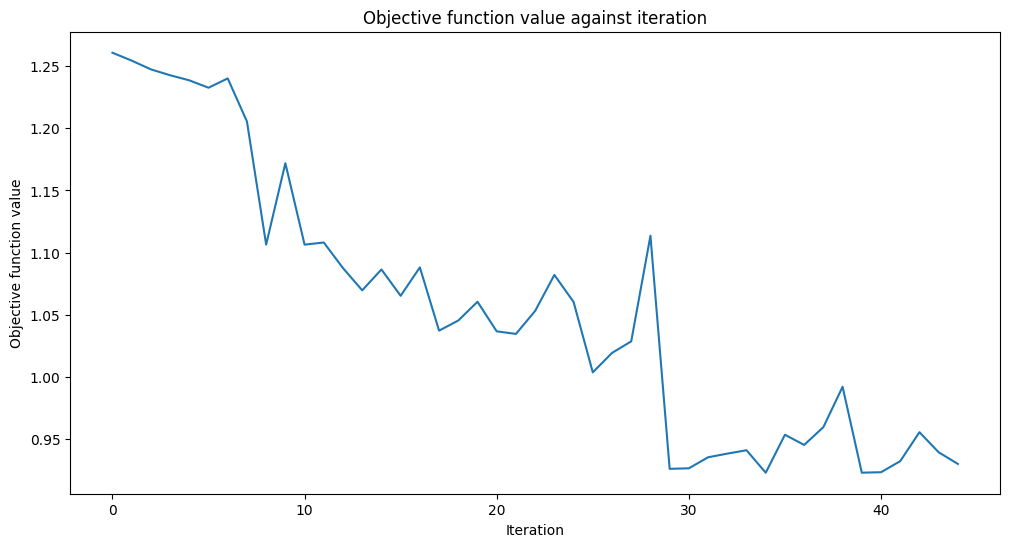

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/opt/anaconda3/envs/qc1/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 281, in calcfc
    f = sf.fun(x)
        ^^^^^^^^^
  File "/opt/anaconda3/envs/qc1/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 325, in fun
    self._update_fun()
  File "/opt/anaconda3/envs/qc1/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 294, in _update_fun
    fx = self._wrapped_fun(self.x)
         ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/qc1/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 20, in wrapped
    fx = fun(np.copy(x), *args)
         ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/choyboy/hc_qml/qiskit_machine_learning/algori

: 

In [22]:
# create empty array for callback to store evaluations of the objective function
objective_vals = []
weight_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_circuits, df_train_classes)
#Replace df_train_angle with list of feature map circuits

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print('Training score=', estimator_classifier.score(train_circuits, df_train_classes))
print('Test score=', estimator_classifier.score(test_circuits, df_test_classes))

# save the classifier
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_class/bond_encoding/cobyla/{initial_layer}_{entangling_layer}_a{atom_factor}/{two_local_initial_layer}_{two_local_entangling_layer}_{ansatz_entanglement}/split{split}/a{ansatz_layers}_m{int(maxiter/1000)}k'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# estimator_classifier.save(f'{newpath}/qml')
# objective_vals = np.array(objective_vals)
# weight_vals = np.array(weight_vals)
# np.savetxt(f"{newpath}/objective_vals", objective_vals)
# np.savetxt(f"{newpath}/weight_vals", weight_vals)

In [17]:
# If basinhopping is used, use the additional following code to locate the lowest minimum found from basin-hopping

# min_ind = f_total.index(min(f_total))
# min_x = x_total[min_ind]
# print(f_total)
# print(accept_total)
# print(min_ind)

min_x = weight_vals[-1]
est = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=1), initial_point=min_x)

est.fit(train_circuits, df_train_classes)
print('Training score=', est.score(train_circuits, df_train_classes))
print('Test score=', est.score(test_circuits, df_test_classes))

Training score= 0.9166666666666666
Test score= 0.7619047619047619


In [18]:
est.predict(test_circuits)

array([[ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.]])

In [19]:
print(df_test_classes)

[ 1 -1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
#Variational quantum regressor

ansatz_layers = 6 #Number of ansatz layers
maxiter = 10000 #Number of iterations for the optimizer
# global_operator = Pauli(("Z") * num_qubits) #Operator for the QNN
global_operator = Pauli(("ZZZZZZZZZZ"))
two_local_initial_layer = 'ry' #Initial layer for the 2-local ansatz
two_local_entangling_layer = 'crx' #Entangling layer for the 2-local ansatz
ansatz_entanglement = 'pairwise' #Entanglement for the ansatz
bh_iterations = 5 #Number of iterations for basin-hopping, basin-hopping happens every maxiter/bh_iterations steps
max_runs = maxiter / bh_iterations
bh_stepsize = 0.01 #Stepsize for basin-hopping
bh_temp = 0 #Temperature for basin-hopping, if 0 then monotonic basin-hopping is carried out

#Choose ansatz
# ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=ansatz_entanglement, reps=ansatz_layers, skip_final_rotation_layer=True)
ansatz = TwoLocal(num_qubits, two_local_initial_layer, two_local_entangling_layer, reps=ansatz_layers, entanglement=ansatz_entanglement, skip_final_rotation_layer=True)
estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    weight_vals.append(weights)
    objective_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_vals)), objective_vals)
    plt.show()

initial_point = (np.random.random(ansatz.num_parameters) - 0.5) * 2 * np.pi 

# Classifier without basin-hopping
estimator_classifier = NeuralNetworkRegressor(
    estimator_qnn, optimizer=COBYLA(maxiter=maxiter), callback=callback_graph, initial_point=initial_point)

#Classifier with basin-hopping

# x_total = []
# f_total = []
# accept_total = []

# # #Enable for optional step-taking
# class MyTakeStep:
#    def __init__(self, stepsize=0.5):
#        self.stepsize = stepsize
#        self.rng = np.random.default_rng()
#    def __call__(self, x):
#        s = self.stepsize
#        x[0] += self.rng.uniform(-2.*s, 2.*s)
#        x[1:] += self.rng.uniform(-s, s, x[1:].shape)
#        return x
   
# mytakestep = MyTakeStep()

# def bh_callback(x, f, accept):
#     x_total.append(x)
#     f_total.append(f)
#     accept_total.append(accept)

# opt = BasinHopping(
#     minimizer_kwargs={"method": 'COBYLA', "jac": False, "options": {"maxiter": max_runs}},
#     options=dict(niter=bh_iterations - 1, stepsize=bh_stepsize, callback=bh_callback, T=bh_temp)
# )

# estimator_classifier = NeuralNetworkRegressor(
#     estimator_qnn, optimizer=opt, callback=callback_graph, initial_point=initial_point)

/var/folders/r2/htkf_rds4gv13rqp6zvxsrkh0000gn/T/ipykernel_92668/3984153014.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=ansatz, input_params=None, observables=global_operator)


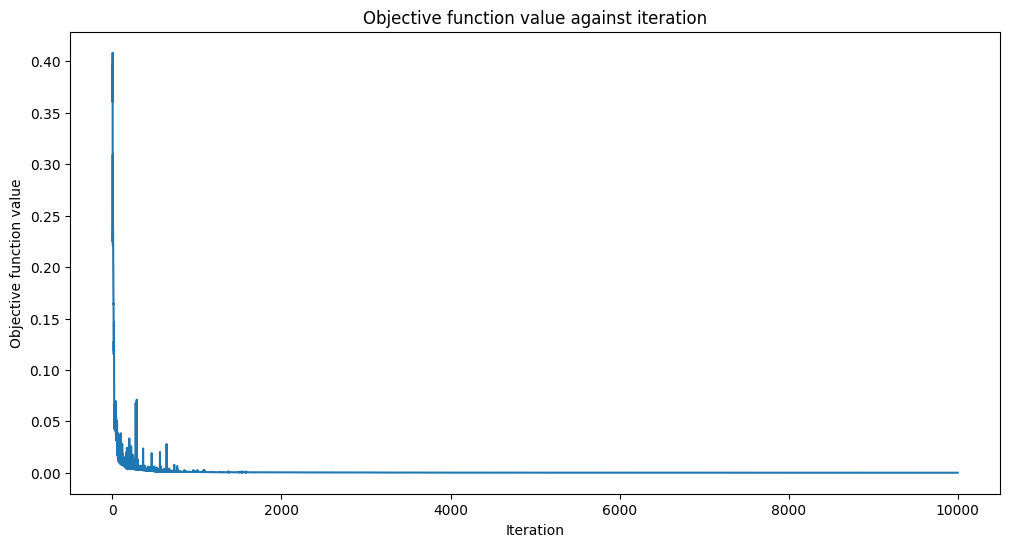

Training score= 0.9976217401660069
Test score= 0.8654463442662976


In [11]:
# create empty array for callback to store evaluations of the objective function
objective_vals = []
weight_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_circuits, df_train_enthalpy)
#Replace df_train_angle with list of feature map circuits

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print('Training score=', estimator_classifier.score(train_circuits, df_train_enthalpy))
print('Test score=', estimator_classifier.score(test_circuits, df_test_enthalpy))

# estimator_classifier.save(f'{newpath}/a{ansatz_layers}_m{int(maxiter/1000)}k')

In [25]:
a = estimator_classifier.weights

In [26]:
# save the regressor
# newpath = f'/Users/choyboy/Documents/Python/QML/hc_regressor/bond_encoding/cobyla/{initial_layer}_{entangling_layer}_a{atom_factor}/{two_local_initial_layer}_{two_local_entangling_layer}_{ansatz_entanglement}/split{split}/a{ansatz_layers}_m{int(maxiter/1000)}k'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# estimator_classifier.save(f'{newpath}/qml')
# objective_vals = np.array(objective_vals)
# weight_vals = np.array(weight_vals)
# np.savetxt(f"{newpath}/objective_vals", objective_vals)
# np.savetxt(f"{newpath}/weight_vals", weight_vals)

In [ ]:
# If basinhopping is used, use the additional following code to locate the lowest minimum found from basin-hopping

min_ind = f_total.index(min(f_total))
min_x = x_total[min_ind]
print(f_total)
print(accept_total)

est = NeuralNetworkRegressor(
    estimator_qnn, optimizer=COBYLA(maxiter=1), initial_point=min_x)

est.fit(train_circuits, df_train_classes)
print('Training score=', est.score(train_circuits, df_train_enthalpy))
print('Test score=', est.score(test_circuits, df_test_enthalpy))

[np.float64(0.0003722540928055419), np.float64(0.00022036320587771242), np.float64(0.00015841609657673384), np.float64(0.00011188360311897734), np.float64(8.297344008471096e-05)]
[True, True, True, True, True]
Training score= 0.9971097334691805
Test score= 0.9172897237549992


In [36]:
estimator_classifier.predict(test_circuits)

array([[-0.16348418],
       [ 0.17328954],
       [ 0.27287892],
       [ 0.49206059],
       [ 0.33509067],
       [ 0.30399625],
       [ 0.25059643],
       [ 0.31878748],
       [ 0.18931423],
       [ 0.34950336]])

In [37]:
print(df_test_enthalpy)

[-0.14424911  0.18602503  0.27437426  0.5         0.33164482  0.33551847
  0.21722288  0.30721097  0.22199046  0.37753278]
